In [3]:
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
from pathlib import Path
import time
import pandas as pd
from scipy.spatial.distance import dice
from utils import plot3, padd_images_to_max, register_image, plot1, print_img_info, resample2target
from EM import ExpectationMaximization
from tqdm import tqdm

In [4]:
train_path = Path().resolve()/'data/Training_Set/'
val_path = Path().resolve()/'data/Validation_Set'
test_path = Path().resolve()/'data/Test_Set'

In [5]:
def multi_atlass(val_set, weight_by=None, power=3):
    # create image placeholders for atlases propagations
    val_img = sitk.ReadImage(str(val_set/f'{val_set.name}.nii.gz'))
    val_img = sitk.Cast(val_img, sitk.sitkFloat64)
    val_segmentation = sitk.ReadImage(str(val_set/f'{val_set.name}_seg.nii.gz'))
    
    
    mean_atlas = sitk.Image(val_img.GetSize(), val_img.GetPixelIDValue())
    mean_atlas.CopyInformation(val_img)
    
    csf_atlas = sitk.Image(val_img.GetSize(), val_img.GetPixelIDValue())
    csf_atlas.CopyInformation(val_img)
    wm_atlas = sitk.Image(val_img.GetSize(), val_img.GetPixelIDValue())
    wm_atlas.CopyInformation(val_img)
    gm_atlas = sitk.Image(val_img.GetSize(), val_img.GetPixelIDValue())
    gm_atlas.CopyInformation(val_img)

    
    # read registration metrics and create weights based on them
    reg_metrics = pd.read_csv(val_set/'results/registration_results.csv')
    
    # need to flip the sign of this metric back to positive
    # so the higher the value of the metric the higher is the weight
    reg_metrics['joint_hist_mi'] = -reg_metrics['joint_hist_mi']
    reg_metrics['mattes_mi'] = -reg_metrics['mattes_mi']
    reg_metrics['correlation'] = -reg_metrics['correlation']

    # need to invert mse so smaller values are result in higher weights
    reg_metrics['mse'] = 1/reg_metrics['mse']
    
    if weight_by is not None:
        reg_metrics = {k:v**power for k,v in reg_metrics[['train_img', weight_by]].values}
    else:
        # if no weight is given, all atlases are equally weighted
        reg_metrics = {k:1 for k in reg_metrics['train_img'].values}
    # normalize the weights to sum to 1
    reg_metrics = {k:v/np.sum(list(reg_metrics.values())) for k, v in reg_metrics.items()}
    
    total_atlases = 0
    for reg_train in (val_set/'results').iterdir():
        if reg_train.is_dir():
            total_atlases+=1
            reg_segm = sitk.ReadImage(str(reg_train/f'{reg_train.name}_seg_reg.nii.gz'))

            csf_atlas = csf_atlas + resample2target(reg_segm == 1, val_img)*reg_metrics[reg_train.name]
            wm_atlas = wm_atlas + resample2target(reg_segm == 2, val_img)*reg_metrics[reg_train.name]
            gm_atlas = gm_atlas + resample2target(reg_segm == 3, val_img)*reg_metrics[reg_train.name]
            
    
    prb_atlas = np.asarray([sitk.GetArrayFromImage(csf_atlas),
                            sitk.GetArrayFromImage(wm_atlas),
                            sitk.GetArrayFromImage(gm_atlas)])
    discr_map = np.argmax(prb_atlas, axis=0) + 1
    
    discr_map[sitk.GetArrayFromImage(val_img) == 0] = 0
    discr_map = sitk.GetImageFromArray(discr_map.astype(np.int16))
    discr_map.CopyInformation(val_img)
    
    
    return discr_map, prb_atlas, val_segmentation, reg_metrics, val_img

In [4]:
results_multi_atlas = []
em = ExpectationMaximization(3)
power = 3
for w in tqdm([None, 'mattes_mi', 'joint_hist_mi', 'correlation', 'mse']):
    for val_set in val_path.iterdir():
        discr_map, prb_atlas, val_segmentation, reg_metrics, val_img = multi_atlass(val_set, weight_by=w, power=power)
        dsc_scores = em.compute_dice(sitk.GetArrayFromImage(val_segmentation), sitk.GetArrayFromImage(discr_map))
        dsc_scores['avg_dsc'] = np.mean(list(dsc_scores.values()))
        dsc_scores['weight_by'] = w
        dsc_scores['power'] = power
        dsc_scores['case'] = val_set.name
        dsc_scores['em'] = 'No'
        results_multi_atlas.append(dsc_scores)
results_multi_atlas = pd.DataFrame(results_multi_atlas)

100%|██████████| 5/5 [01:37<00:00, 19.44s/it]


In [6]:
results_multi_atlas_em = []
em = ExpectationMaximization(3)
power = 3
for w in tqdm([None, 'mattes_mi', 'joint_hist_mi', 'correlation', 'mse']):
    for val_set in val_path.iterdir():
        discr_map, prb_atlas, val_segmentation, reg_metrics, val_img = multi_atlass(val_set, weight_by=w, power=power)
        dsc_scores = em.compute_dice(sitk.GetArrayFromImage(val_segmentation), sitk.GetArrayFromImage(discr_map))
        dsc_scores['avg_dsc'] = np.mean(list(dsc_scores.values()))
        dsc_scores['weight_by'] = w
        dsc_scores['power'] = power
        dsc_scores['case'] = val_set.name
        dsc_scores['em'] = 'No'
        
        EM = ExpectationMaximization(4, init_method='kmeans')
        em_segm = EM.segment(images=[sitk.GetArrayFromImage(val_img)],
                             mask=sitk.GetArrayFromImage(val_img != -10),
                            #  segmentation=sitk.GetArrayFromImage(discr_map),
                            #  tissue_atlasses=prb_atlas,
                            )
        em_dsc = EM.compute_dice(sitk.GetArrayFromImage(val_segmentation), em_segm)
        print(em_dsc)
        for k, v in em_dsc.items():
            dsc_scores[f'em_{k}'] = v
        dsc_scores[f'em_avg_dsc'] = np.mean(list(em_dsc.values()))
        results_multi_atlas_em.append(dsc_scores)
results_multi_atlas_em = pd.DataFrame(results_multi_atlas_em)

  0%|          | 0/5 [00:00<?, ?it/s]

{'CSF': 0.031243280896559443, 'WM': 0.0, 'GM': 0.0}


  0%|          | 0/5 [00:14<?, ?it/s]


KeyboardInterrupt: 

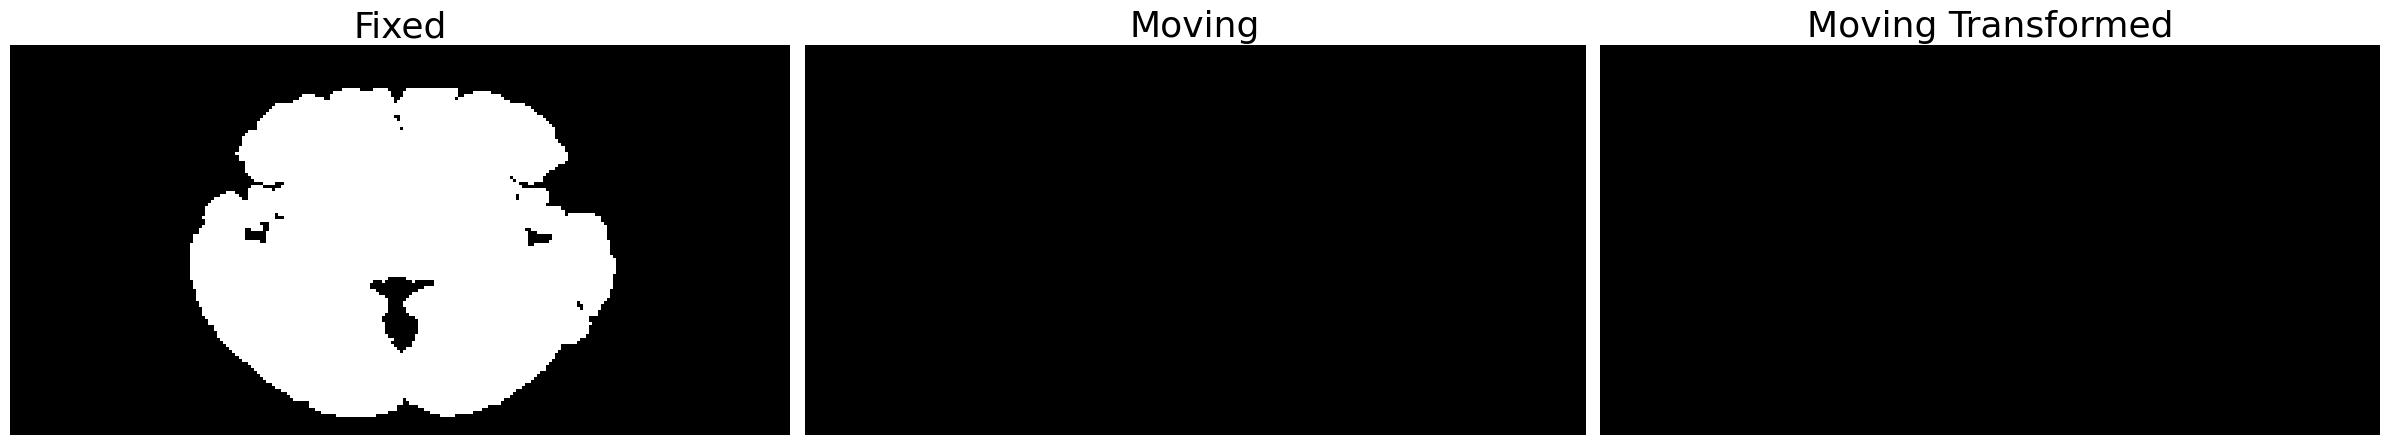

In [18]:
em_segm_sitk = sitk.GetImageFromArray(em_segm)

plot3(em_segm_sitk==1, em_segm_sitk==2, em_segm_sitk == 3)

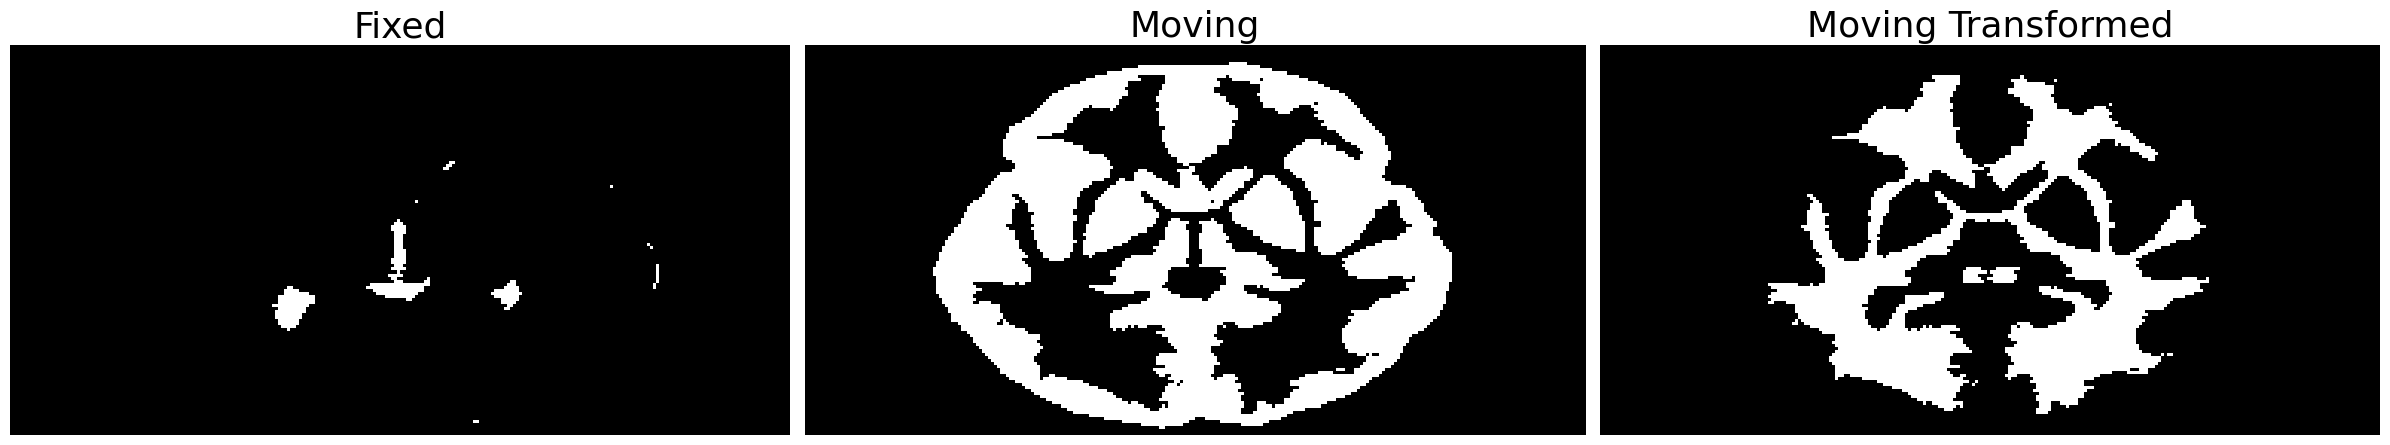

In [8]:
plot3(discr_map==1, discr_map==2, discr_map == 3)

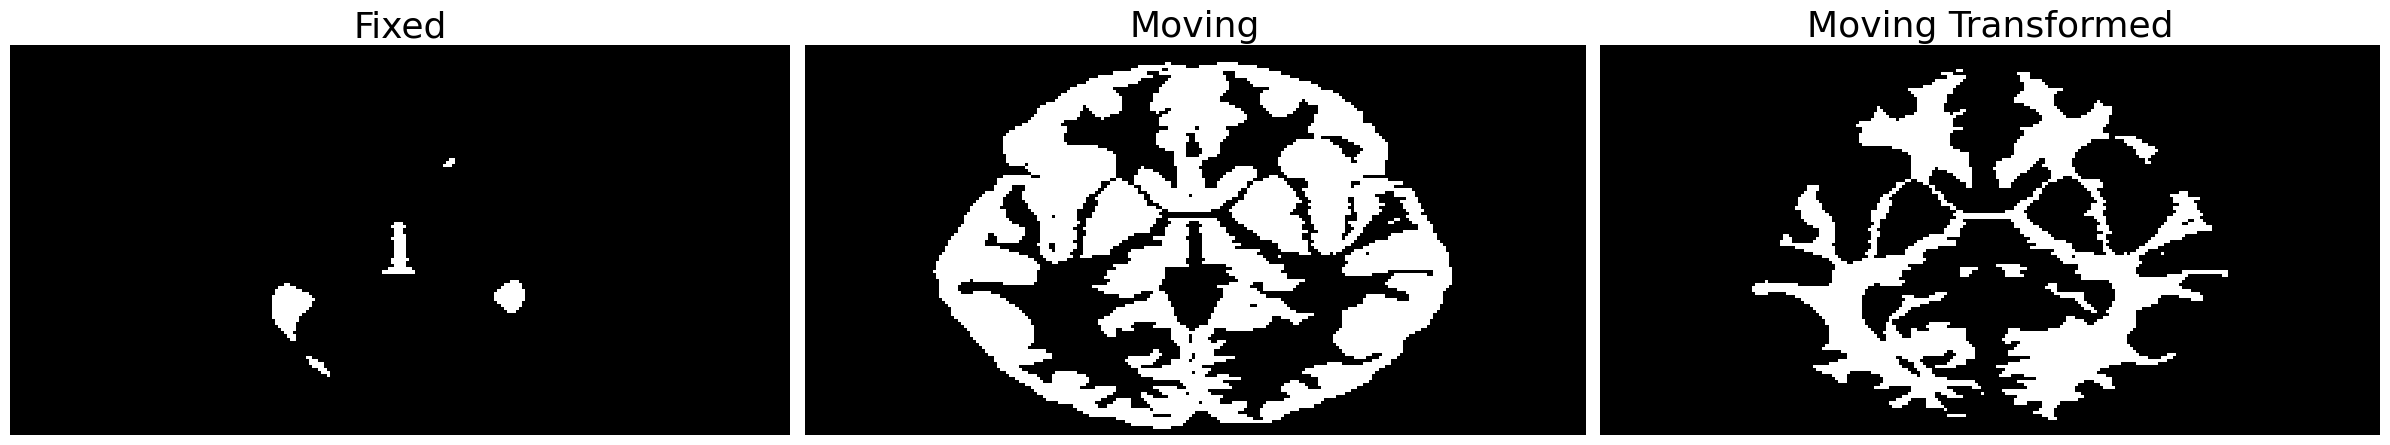

In [9]:
plot3(val_segmentation==1, val_segmentation==2, val_segmentation==3)

In [9]:
sitk.GetArrayFromImage(val_segmentation>0).shape

(256, 128, 256)

In [10]:
discr_map

<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x7f0c03b9e7c0> >

In [21]:
s = sitk.GetArrayFromImage(discr_map)
np.unique(s[sitk.GetArrayFromImage(val_segmentation)>0], return_counts=True)

(array([0, 1, 2, 3], dtype=int16), array([  3993,  10350, 542432, 333221]))

In [22]:
EM = ExpectationMaximization(3, init_method='segm')
em_segm = EM.segment(images=[sitk.GetArrayFromImage(val_img)],
                     mask=sitk.GetArrayFromImage(val_segmentation)>0,
                     segmentation=sitk.GetArrayFromImage(discr_map),
                    #  tissue_atlasses=prb_atlas,
                    )

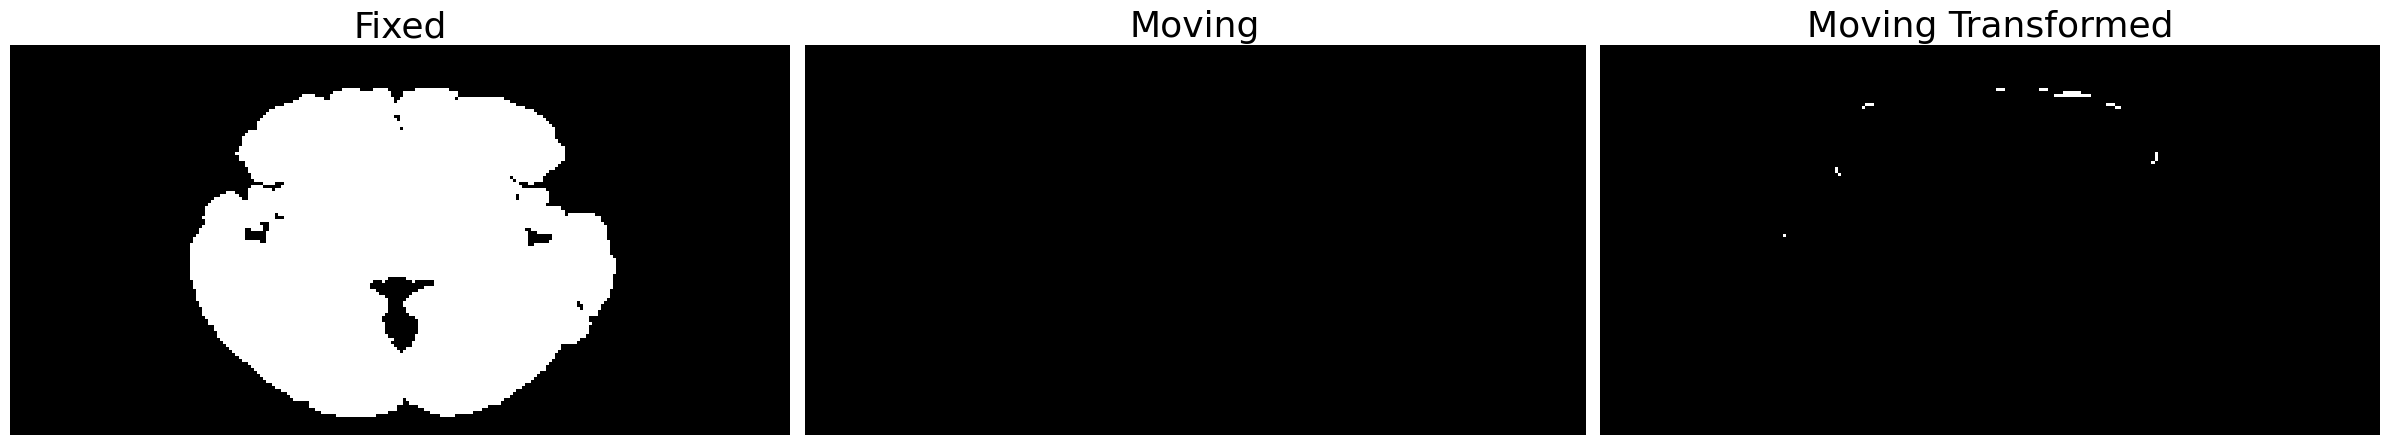

In [23]:
em_segm_sitk = sitk.GetImageFromArray(em_segm)

plot3(em_segm_sitk==1, em_segm_sitk==2, em_segm_sitk == 3)

In [48]:
from sklearn.mixture import GaussianMixture

In [70]:
discr_map_np = sitk.GetArrayFromImage(discr_map)
val_img_np = sitk.GetArrayFromImage(val_img)
weights_init = np.asarray([(discr_map_np == l).sum()/(discr_map_np!=0).sum() for l in [1, 2, 3]])
means_init = np.asarray([[val_img_np[discr_map_np == l].mean() for l in [1, 2, 3]]]).T

precisions_init = np.asarray([np.cov(val_img_np[discr_map_np == l]) for l in [1, 2, 3]]).reshape(3, 1, 1)

In [81]:
gm = GaussianMixture(n_components=3,
                     covariance_type='full',
                     max_iter=1000, n_init=10,
                     random_state=0,
                     weights_init=weights_init,
                     means_init=means_init,
                     precisions_init=precisions_init,)

pred_labels = gm.fit_predict(val_img_np[val_img_np != 0].reshape(-1, 1))

In [82]:
em_pred = np.zeros_like(val_img_np)
em_pred[val_img_np != 0] = pred_labels + 1
EM.compute_dice(sitk.GetArrayFromImage(val_segmentation), em_pred)

{'CSF': 0.2094066860756952, 'WM': 0.848974666049511, 'GM': 0.8391518693456169}

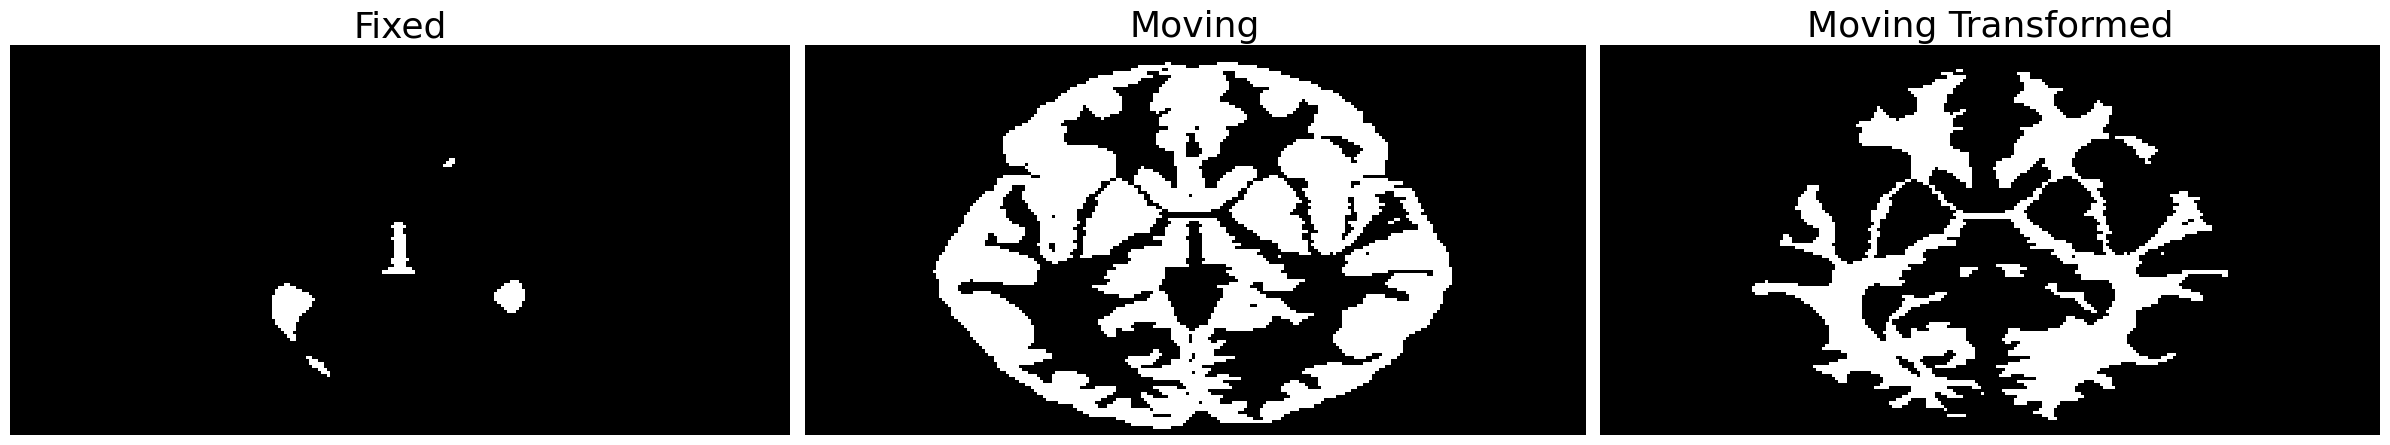

In [83]:
plot3(val_segmentation==1, val_segmentation==2, val_segmentation==3)

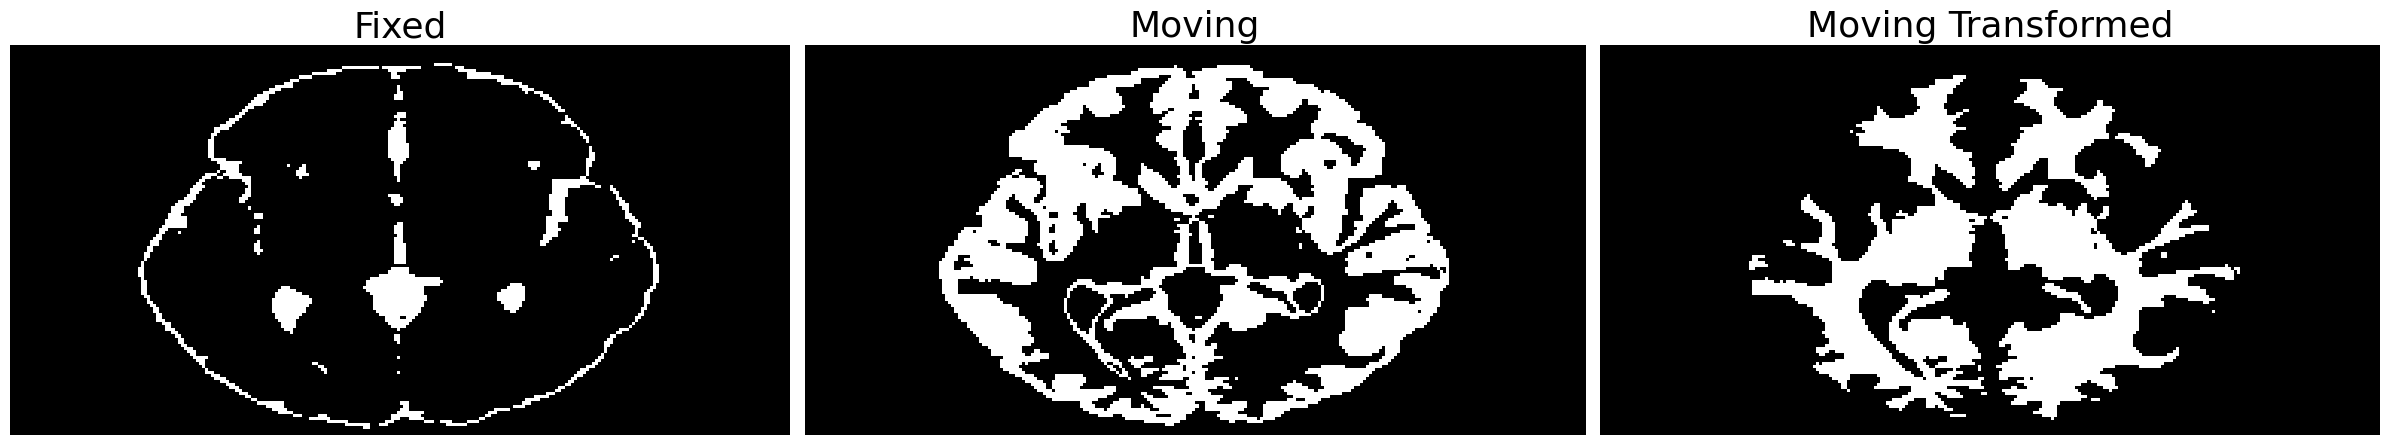

In [84]:
t = sitk.GetImageFromArray(em_pred.astype(np.int16))
plot3(t==1, t==2, t==3)

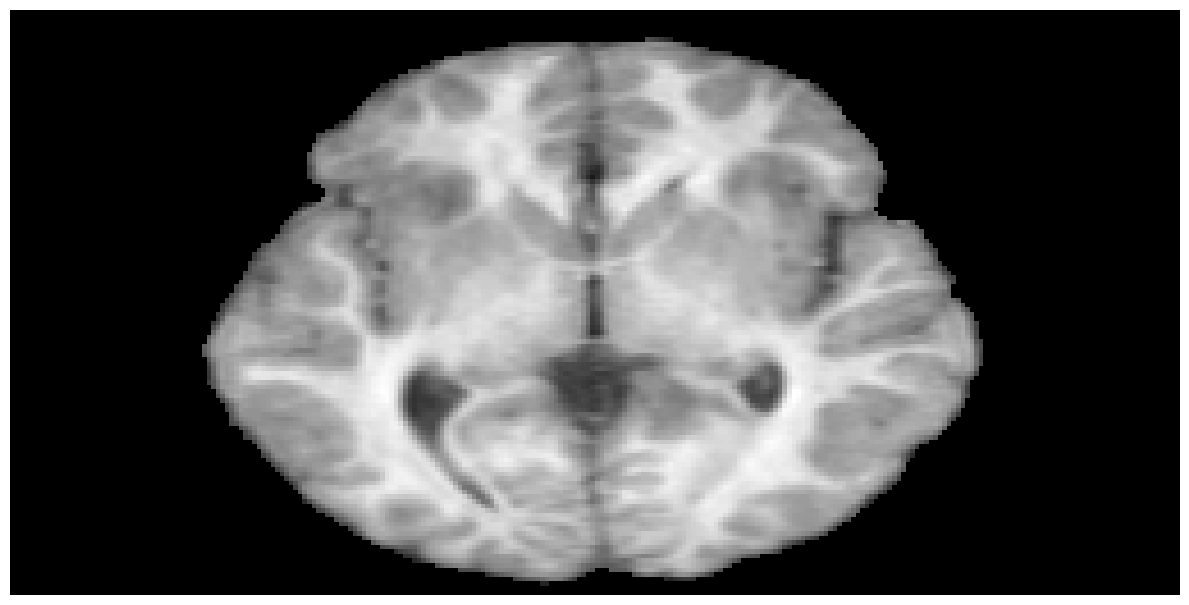

In [87]:
plot1(val_img)